In [1]:
import random
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

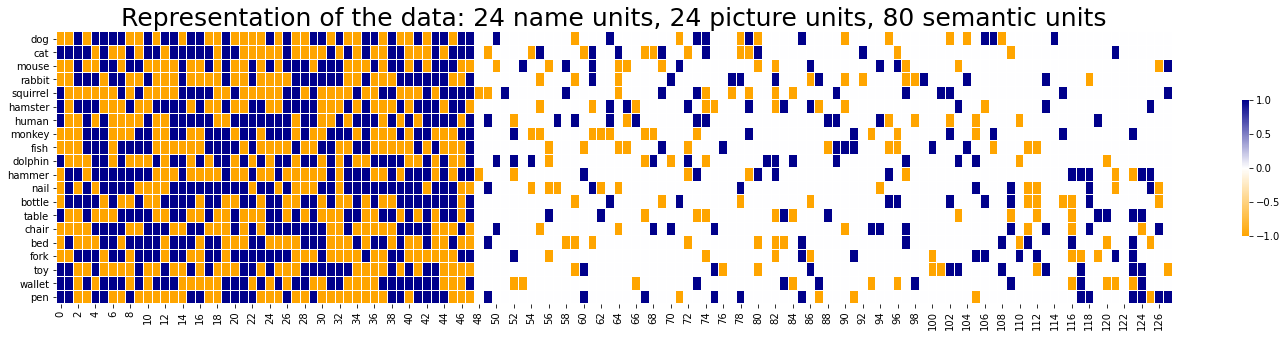

In [2]:
def generate_data(network_architecture, nouns, proportions):
    '''
    Data generation function
    
    Parameters:
    
    network_architecture: a dictionary containing the size of each layer
    nouns:                a list of living and non-living things
    
    Returns: a random pattern of 1 and -1 for each noun
    
    '''

    random.seed(1)  # for reproducible results of the random operations

    noun_activations = {}

    for animation, noun_list in nouns.items():
        
        n_visual = proportions[animation][0]
        n_functional = proportions[animation][1]
        
        for noun in noun_list:
                        
            # Define a random pattern of name and visual input/output units:
            name_values = [random.choice([-1, 1]) for i in range(network_architecture['name_inputs'])]
            picture_values = [random.choice([-1, 1]) for i in range(network_architecture['picture_inputs'])]

            # Initialize the semantic units as zeroes
            semantic_visual_values = [0] * network_architecture['semantic_visual']
            semantic_functional_values = [0] * network_architecture['semantic_functional']
    
            visual_indices=random.sample(range(60), n_visual)
            visual_replacements = [random.choice([-1, 1]) for i in range(n_visual)]

            for (i, replacement) in zip(visual_indices, visual_replacements):
                semantic_visual_values[i] = replacement
        
            functional_indices=random.sample(range(20), n_functional)
            functional_replacements = [random.choice([-1, 1]) for i in range(n_functional)]
            for (i, replacement) in zip(functional_indices, functional_replacements):
                semantic_functional_values[i] = replacement
            
            #noun_activations[animation][noun] = name_values + picture_values + \
            #                                    semantic_visual_values + semantic_functional_values
            noun_activations[noun] = name_values + picture_values + \
                                     semantic_visual_values + semantic_functional_values
            
    return noun_activations
            

# List of nouns, divided into animate and non-animate
nouns={'anim': ['dog', 'cat', 'mouse', 'rabbit', 'squirrel', 'hamster',
                'human', 'monkey', 'fish', 'dolphin'],
       'non-anim': ['hammer', 'nail', 'bottle', 'table', 'chair', 'bed',
                    'fork', 'toy', 'wallet', 'pen']}

# Proportion of visual to functional units for each class
proportion_visual_functional={'anim': (16, 2),
                              'non-anim': (10, 7)}

# Network architecture
network={'name_inputs': 24,
         'picture_inputs': 24,
         'semantic_visual': 60,
         'semantic_functional': 20}

data = pd.DataFrame(generate_data(network, nouns, proportion_visual_functional)).T
fig, ax = plt.subplots(figsize=(25,5))

# Visualize the data
cmap = LinearSegmentedColormap.from_list('GreenWhiteRed', ['orange', 'white', 'darkblue'])
sns.heatmap(data, annot=False, cmap=cmap, vmin=-1, vmax=1, linewidths=0.01,
            linecolor='white', cbar_kws={'shrink': .5}, ax=ax)
plt.title("Representation of the data: 24 name units, 24 picture units, 80 semantic units", fontsize=25)
plt.show()

In [3]:
class Model(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        nn.Module.__init__(self)
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.names2outputs = nn.Linear(n_inputs,n_outputs, bias=False)
        self.pictures2outputs = nn.Linear(n_inputs,n_outputs, bias=False)

    def forward_names(self, input):
        name = input
        #name = Variable(input[:self.n_inputs])
        #picture = Variable(input[self.n_inputs:self.n_items])
        out = self.names2outputs(name)
        #out = F.tanh(out)
        return out
    
    def forward_pictures(self, input):
        picture = input
        out = self.pictures2outputs(picture)
        #out = F.tanh(out)
        return out
    
    def lesion(self, nodes):
        for n in nodes:
            self.names2outputs.weight.data[:][n] = 0
            self.pictures2outputs.weight.data[:][n] = 0

In [4]:
labels = ['dog', 'cat', 'mouse', 'rabbit', 'squirrel', 'hamster', 'human', 'monkey', 'fish', 'dolphin',
        'hammer', 'nail', 'bottle', 'table', 'chair', 'bed', 'fork', 'toy', 'wallet', 'pen']


def classify(prediction, level, data):
    
    sims = []
    
    for i, pattern in enumerate(data):
        
        # Split the pattern into inputs (name+picture) and target
        names = pattern[:n_inputs]
        pictures = pattern[n_inputs:-n_outputs]
        semantic = pattern[-n_outputs:]

        if level == 'names':
            sims.append(cosinesim(prediction, names))
        elif level == 'pictures':
            sims.append(cosinesim(prediction, pictures))
        elif level == 'semantic':
            sims.append(cosinesim(prediction, semantic))
                    
    chosen_ind = sims.index(max(sims))
    
    return chosen_ind


def train(train_data, model, epochs, learning_rate, sim_function, weight_decay=0, momentum = 0):
    '''
    Parameters:

    train_data:    the data to be trained on
    model:         the model to be trained
    epochs:        the number of epochs
    learning_rate: the size of steps in the direction of steepest descent
    
    '''
    
    print("Now training the model...")
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # SGD
    criterion = nn.MSELoss()  # MSE as loss function
    model.train()
    
    losses_names = []
    sims_names = []
    losses_pictures = []
    sims_pictures = []
    accs = []
    
    for e in range(epochs):
        
        running_loss_names = 0.0
        running_loss_pictures = 0.0
        running_sim_names = 0.0
        running_sim_pictures = 0.0
        running_acc = 0.0
        
        for i, pattern in enumerate(train_data):
            
            # Split the pattern into inputs (name+picture) and target
            names = pattern[:n_inputs]
            pictures = pattern[n_inputs:-n_outputs]
            targets = pattern[-n_outputs:]

            # Train with names
            optimizer.zero_grad()  # clear gradients 
            outputs_names = model.forward_names(names) # forward pass
            loss_names = criterion(outputs_names, targets) # compute loss
            loss_names.backward()  # calculate how to change weights
            optimizer.step()  # update weights using optimizer 
            sim_names = sim_function(targets, outputs_names) # calculate similarity between prediction & target
            
            running_loss_names += loss_names.item()
            running_sim_names += sim_names.item()

            # Train with pictures
            optimizer.zero_grad()  # clear gradients 
            outputs_pictures = model.forward_pictures(pictures) # forward passå
            loss_pictures = criterion(outputs_pictures, targets)  # compute loss
            loss_pictures.backward()  # calculate how to change weights
            optimizer.step()   # update weights using optimizer 
            sim_pictures = sim_function(targets, outputs_pictures) # calculate similarity between prediction & target
            
            # Classify
            name_ind = classify(outputs_names, 'semantic', train_data)
            pict_ind = classify(outputs_pictures, 'semantic', train_data)
        
            #print("\nTesting noun: {}".format(labels[i].upper()))
            #print("\tpicture-to-name: {}".format(labels[name_ind]))
            #print("\tname-to-picture: {}".format(labels[pict_ind]))
        
            if name_ind == i:
                running_acc += 1
            if pict_ind == i:
                running_acc += 1
            
            running_loss_pictures += loss_pictures.item()
            running_sim_pictures += sim_pictures.item()
            
        losses_names.append(running_loss_names / 20)
        sims_names.append(running_sim_names / 20)
        losses_pictures.append(running_loss_pictures / 20)
        sims_pictures.append(running_sim_pictures / 20) 
        accs.append(running_acc / 40)
        
    print("Model training complete.")
                
    return losses_names, sims_names, losses_pictures, sims_pictures, accs


def test(test_data, names, model, sim_function, options):

    model.eval()  # put model in test mode to prevent further weight changes
    
    name_predictions = {}
    picture_predictions = {}
    name_learned = {}
    picture_learned = {}
    
    acc = 0.0
    acc_living = 0.0
    acc_nonliving = 0.0
    
    for i, pattern in enumerate(train_data):
        
        noun_label = labels[i]
        
        # Split the pattern into inputs (name+picture) and target
        names = pattern[:n_inputs]
        pictures = pattern[n_inputs:-n_outputs]
        targets = pattern[-n_outputs:]   
        
        # Compute the predictions from names to pictures (picture selection task)
        sem = model.forward_names(names)
        picture_pred = torch.matmul(model.pictures2outputs.weight.data.T, sem)
        picture_sim = sim_function(pictures, picture_pred)
        picture_predictions[noun_label+"_target"] = pictures.detach().numpy()
        picture_predictions[noun_label+"_predic"] = picture_pred.detach().numpy()
        picture_predictions[" " * i] = [0] * n_inputs  # placeholder line for space
        picture_learned[noun_label] = [abs(i - j) for i,j in zip(pictures.detach().numpy(),
                                                                 picture_pred.detach().numpy())]

        # Compute the predictions from pictures to names (picture naming task)
        sem = model.forward_pictures(pictures)
        name_pred = torch.matmul(model.names2outputs.weight.data.T, sem)
        name_sim = sim_function(names, name_pred)
        name_predictions[noun_label+"_target"] = names.detach().numpy()
        name_predictions[noun_label+"_predic"] = name_pred.detach().numpy()
        name_predictions[" " * i] = [0] * n_inputs  # placeholder line for space
        name_learned[noun_label] = [abs(i - j) for i,j in zip(names.detach().numpy(),
                                                              name_pred.detach().numpy())] 
        
        # Classify
        name_ind = classify(name_pred, 'names', train_data)
        pict_ind = classify(picture_pred, 'pictures', train_data)
        
        if options == "print_progress":
            print("\nTesting noun: {}".format(labels[i].upper()))
            print("\tpicture-to-name: {}".format(labels[name_ind]))
            print("\tname-to-picture: {}".format(labels[pict_ind]))
        
        if name_ind == i:
            acc += 1
            if i<10:
                acc_living += 1
            else:
                acc_nonliving += 1
        if pict_ind == i:
            acc += 1
            if i<10:
                acc_living += 1
            else:
                acc_nonliving += 1
            
    acc = acc / ((i+1)*2)
    acc_living = acc_living / (i+1)
    acc_nonliving = acc_nonliving / (i+1)
    
    if options == "print_progress":
        print("_" * 50)
        print("\nTest accuracy: {}%".format(acc*100))
        
    elif options == "lesioned":
        #print("\nMean test accuracy:\t{}%".format(acc*100))
        #print("Accuracy living:\t{}%".format(acc_living*100))
        #print("Accuracy nonliving:\t{}%".format(acc_nonliving*100))
        
        return acc_living, acc_nonliving
      
    elif options == "print_plots":
        
        print("\nInspect model performance on a per-unit basis")
        
        cmap = LinearSegmentedColormap.from_list('GreenWhiteRed', ['green', 'white', 'red'])
    
        name_learned = pd.DataFrame(name_learned).T
        fig, ax = plt.subplots(figsize=(10,6))
        sns.heatmap(name_learned, annot=False, cmap=cmap, vmin=0, vmax=2, linewidths=1,
                    linecolor='white', cbar_kws={'shrink': .5, 'label': 'Error (from 0 to 2)'}, ax=ax)
        plt.title("Name prediction accuracy", fontsize=25)   
        plt.show()

        picture_learned = pd.DataFrame(picture_learned).T
        fig, ax = plt.subplots(figsize=(10,6))
        sns.heatmap(picture_learned, annot=False, cmap=cmap, vmin=0, vmax=2, linewidths=1,
                    linecolor='white', cbar_kws={'shrink': .5, 'label': 'Error (from 0 to 2)'}, ax=ax)
        plt.title("Picture prediction accuracy", fontsize=25)   
        plt.show()

        cmap = LinearSegmentedColormap.from_list('GreenWhiteRed', ['orange', 'white', 'darkblue'])

        name_predictions = pd.DataFrame(name_predictions).T
        fig, ax = plt.subplots(figsize=(10,20))
        sns.heatmap(name_predictions, annot=False, cmap=cmap, vmin=-1, vmax=1,
                    linewidths=1, linecolor='white', cbar_kws={"shrink": .2}, ax=ax)
        plt.title("Picture naming task (target vs. predicted)", fontsize=25)   
        plt.show()

        picture_predictions = pd.DataFrame(picture_predictions).T
        fig, ax = plt.subplots(figsize=(10,20))
        sns.heatmap(picture_predictions, annot=False, cmap=cmap, vmin=-1, vmax=1,
                    linewidths=1, linecolor='white', cbar_kws={"shrink": .2}, ax=ax)
        plt.title("Name-2-picture task (target vs. predicted)", fontsize=25)   
        plt.show()

In [5]:
n_epochs = 100
learning_rate = 0.1
cosinesim = nn.CosineSimilarity(dim=0)
n_inputs, n_outputs = 24, 80

dtype = torch.float
device = torch.device("cpu")

# Prepare the training data
train_data = torch.from_numpy(data.values.astype(np.float32, copy=False))

# Create the model
torch.manual_seed(1)
model = Model(n_inputs, n_outputs)

# Test the untrained model on the picture naming and name-2-picture tasks
test(train_data, labels, model, cosinesim, "print_progress")


Testing noun: DOG
	picture-to-name: monkey
	name-to-picture: human

Testing noun: CAT
	picture-to-name: rabbit
	name-to-picture: bottle

Testing noun: MOUSE
	picture-to-name: wallet
	name-to-picture: human

Testing noun: RABBIT
	picture-to-name: toy
	name-to-picture: human

Testing noun: SQUIRREL
	picture-to-name: rabbit
	name-to-picture: wallet

Testing noun: HAMSTER
	picture-to-name: monkey
	name-to-picture: hammer

Testing noun: HUMAN
	picture-to-name: hammer
	name-to-picture: dog

Testing noun: MONKEY
	picture-to-name: dolphin
	name-to-picture: dog

Testing noun: FISH
	picture-to-name: toy
	name-to-picture: dog

Testing noun: DOLPHIN
	picture-to-name: mouse
	name-to-picture: table

Testing noun: HAMMER
	picture-to-name: hamster
	name-to-picture: human

Testing noun: NAIL
	picture-to-name: table
	name-to-picture: chair

Testing noun: BOTTLE
	picture-to-name: wallet
	name-to-picture: pen

Testing noun: TABLE
	picture-to-name: dolphin
	name-to-picture: nail

Testing noun: CHAIR
	pict

In [6]:
# Train the model
losses_names, sims_names, losses_pictures, sims_pictures, accs = train(train_data, model, n_epochs, learning_rate, \
                                                                       cosinesim, weight_decay=0.005, momentum=0)

Now training the model...
Model training complete.


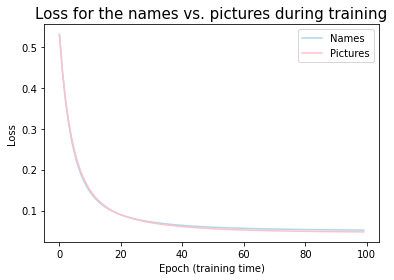

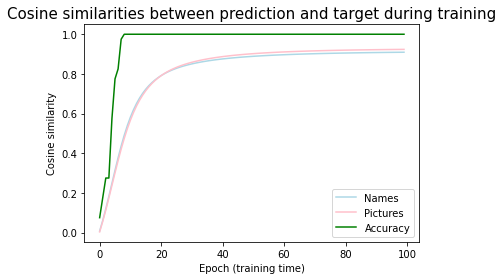

In [7]:
# Plot losses over the course of training
plt.plot(losses_names, 'lightblue', label="Names")
plt.plot(losses_pictures, 'pink', label="Pictures")
plt.legend(loc="upper right")
plt.xlabel("Epoch (training time)")
plt.ylabel("Loss")
plt.title("Loss for the names vs. pictures during training", fontsize=15)
plt.show()

# Plot cosine similarities over the course of training 
plt.plot(sims_names, 'lightblue', label="Names")
plt.plot(sims_pictures, 'pink', label="Pictures")
plt.plot(accs, 'green',  label="Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch (training time)")
plt.ylabel("Cosine similarity")
plt.title("Cosine similarities between prediction and target during training", fontsize=15)
plt.show()

In [8]:
# Test the trained model on the picture naming and name-2-picture tasks
test(train_data, labels, model, cosinesim, "print_progress")


Testing noun: DOG
	picture-to-name: dog
	name-to-picture: dog

Testing noun: CAT
	picture-to-name: cat
	name-to-picture: cat

Testing noun: MOUSE
	picture-to-name: mouse
	name-to-picture: mouse

Testing noun: RABBIT
	picture-to-name: rabbit
	name-to-picture: rabbit

Testing noun: SQUIRREL
	picture-to-name: squirrel
	name-to-picture: squirrel

Testing noun: HAMSTER
	picture-to-name: hamster
	name-to-picture: hamster

Testing noun: HUMAN
	picture-to-name: human
	name-to-picture: human

Testing noun: MONKEY
	picture-to-name: monkey
	name-to-picture: monkey

Testing noun: FISH
	picture-to-name: fish
	name-to-picture: fish

Testing noun: DOLPHIN
	picture-to-name: dolphin
	name-to-picture: dolphin

Testing noun: HAMMER
	picture-to-name: hammer
	name-to-picture: hammer

Testing noun: NAIL
	picture-to-name: nail
	name-to-picture: nail

Testing noun: BOTTLE
	picture-to-name: bottle
	name-to-picture: bottle

Testing noun: TABLE
	picture-to-name: table
	name-to-picture: table

Testing noun: CHAI


Inspect model performance on a per-unit basis


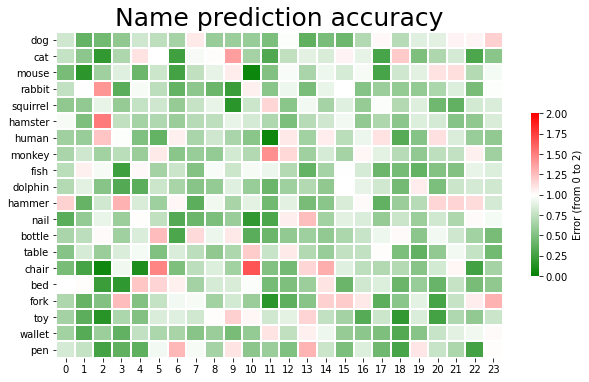

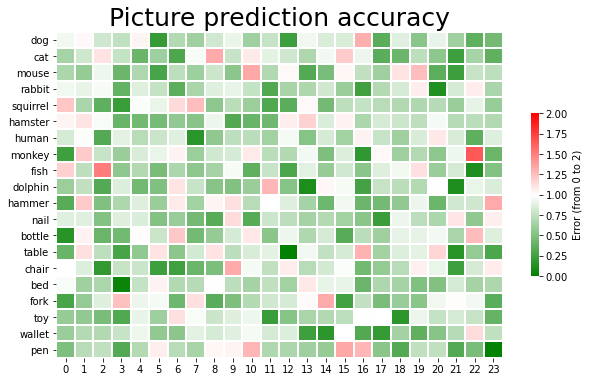

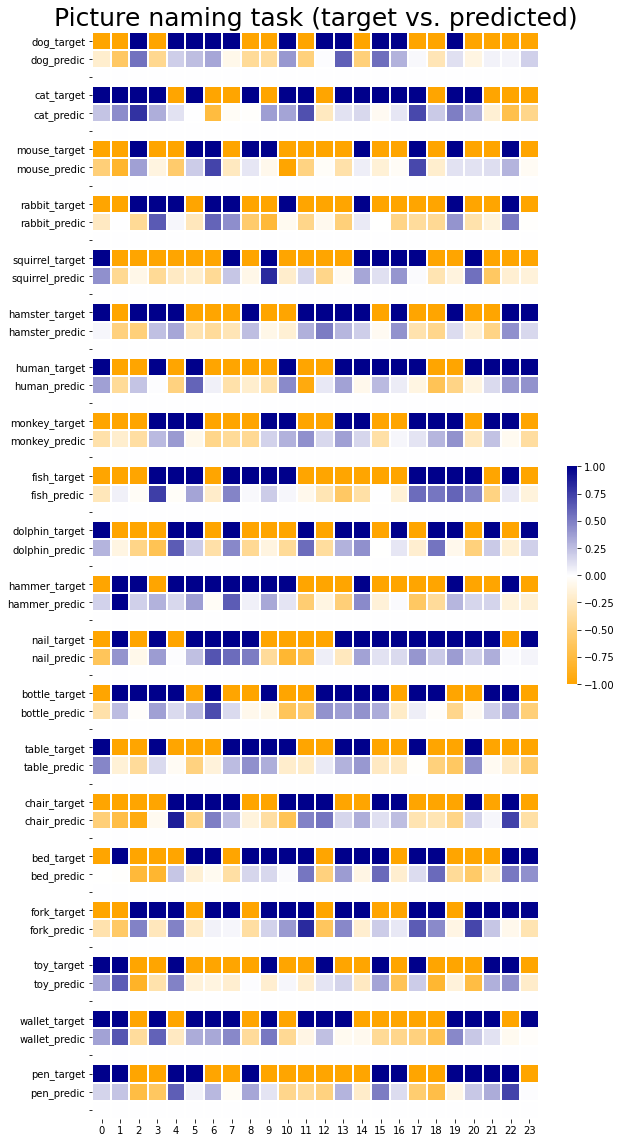

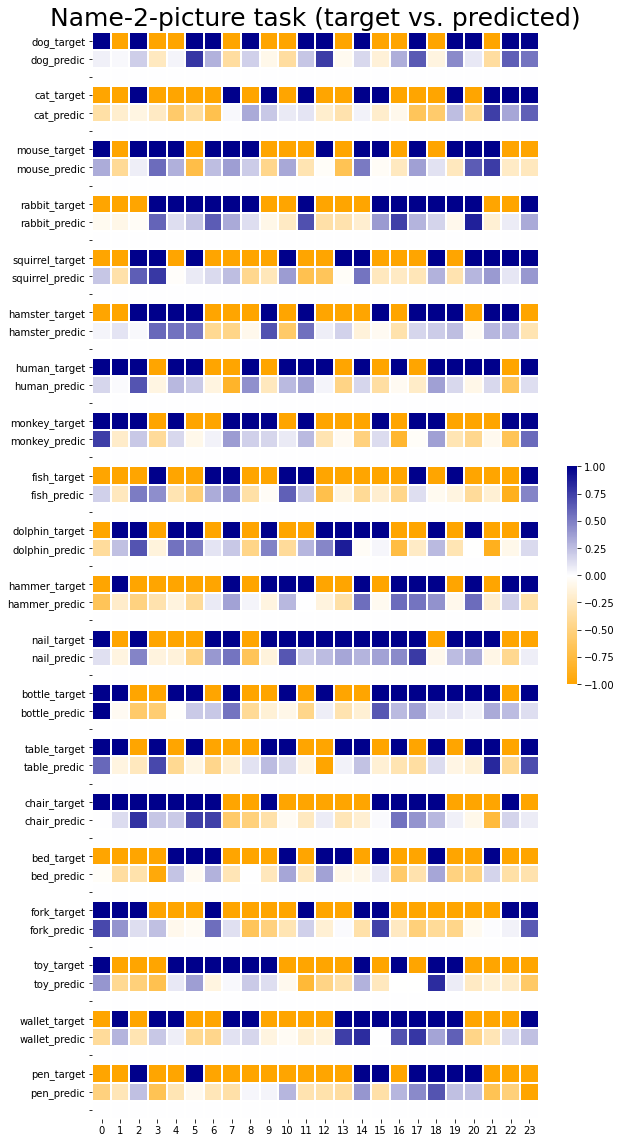

In [9]:
test(train_data, labels, model, cosinesim, "print_plots")

In [10]:
# Damage the semantic visual units

random.seed(1)

vis_percentages = [0, 12, 24, 36, 48, 59]
fun_percentages = [0, 4, 8, 12, 16, 19]
  
n_iter = 10

mean_vis_liv_accs = []
mean_vis_nonliv_accs = []
mean_fun_liv_accs = []
mean_fun_nonliv_accs = []

# Damage semantic visual memory
for j, p in enumerate(vis_percentages):
    mean_vis_liv_accs.append(0.0)
    mean_vis_nonliv_accs.append(0.0)
    for i in range(n_iter):
        nodes = random.sample(range(60), p)
        new_model = copy.deepcopy(model)
        new_model.lesion(nodes)
        liv_acc, nonliv_acc = test(train_data, labels, new_model, cosinesim, "lesioned")
        mean_vis_liv_accs[j] += liv_acc
        mean_vis_nonliv_accs[j] += nonliv_acc

# Damage semantic functional memory
for j, p in enumerate(fun_percentages):
    mean_fun_liv_accs.append(0.0)
    mean_fun_nonliv_accs.append(0.0)
    for i in range(n_iter):
        nodes = random.sample(range(60), p)
        new_model = copy.deepcopy(model)
        new_model.lesion(nodes)
        liv_acc, nonliv_acc = test(train_data, labels, new_model, cosinesim, "lesioned")
        mean_fun_liv_accs[j] += liv_acc
        mean_fun_nonliv_accs[j] += nonliv_acc

mean_vis_liv_accs = [x*10 for x in mean_vis_liv_accs]
mean_vis_nonliv_accs = [x*10 for x in mean_vis_nonliv_accs]
mean_fun_liv_accs = [x*10 for x in mean_fun_liv_accs]
mean_fun_nonliv_accs = [x*10 for x in mean_fun_nonliv_accs]

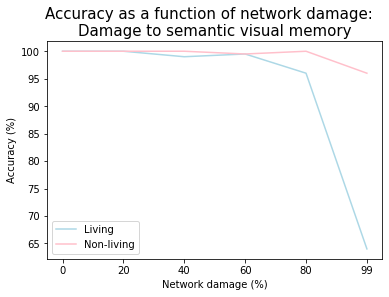

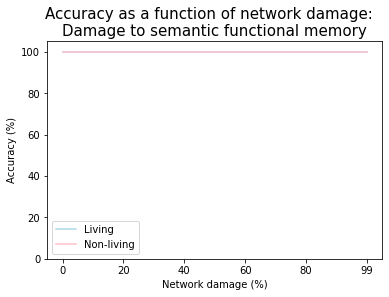

In [11]:
# Plot performance of model by lesion

xticks = [0, 1, 2, 3, 4, 5]
xticklabels = [0, 20, 40, 60, 80, 99]

# Lesion to visual 
fig, ax = plt.subplots()
plt.plot(mean_vis_liv_accs, 'lightblue', label="Living")
plt.plot(mean_vis_nonliv_accs, 'pink', label="Non-living")
plt.legend(loc="lower left")
plt.xlabel("Network damage (%)")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
plt.ylabel("Accuracy (%)")
plt.suptitle("Accuracy as a function of network damage:", fontsize=15, y=1)
plt.title("Damage to semantic visual memory", fontsize=15)
plt.show()

# Lesion to functional2
fig, ax = plt.subplots()
plt.plot(mean_fun_liv_accs, 'lightblue', label="Living")
plt.plot(mean_fun_nonliv_accs, 'pink', label="Non-living")
plt.legend(loc="lower left")
plt.xlabel("Network damage (%)")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylim([0,105])
plt.ylabel("Accuracy (%)")
plt.suptitle("Accuracy as a function of network damage:", fontsize=15, y=1)
plt.title("Damage to semantic functional memory", fontsize=15)
plt.show()